# Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# %cd /content/drive/MyDrive/CS221 - Xử lý ngôn ngữ tự nhiên/Đồ án NLP/wikitext-103-v1
%cd /content/drive/MyDrive/CS221 - Xử lý ngôn ngữ tự nhiên/Đồ án NLP/wikitext-2

/content/drive/MyDrive/CS221 - Xử lý ngôn ngữ tự nhiên/Đồ án NLP/wikitext-2


In [3]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

# Set global variables

In [4]:
# global variables
DATA_TRAIN = 'word_data_wikitext_2_train.txt'
DATA_TEST = 'word_data_wikitext_2_test.txt'
DATA_VALID = 'word_data_wikitext_2_valid.txt'

# DATA_TRAIN = 'processed_train.txt'
# DATA_TEST = 'processed_test.txt'
# DATA_VALID = 'processed_valid.txt'


BIGRAMS = 'bigrams_count.csv'
SEP_BIGRAMS = 'bigrams_count_sep.csv'
CONTINUATION_PROBABILITY = 'continuation_prob.csv'
LAMBDA = 'lambda.csv'
UNIGRAMS = 'unigrams_count.csv'

PROB = 'pkn.csv'

DISCOUNT = 0.75

In [5]:
import re
import sys
import csv
import time
import nltk
import numpy as np
import pandas as pd
from copy import deepcopy
from nltk.tokenize import sent_tokenize
from torchtext.data import get_tokenizer
from torchtext.data.utils import ngrams_iterator
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Helper functions

In [7]:
def ngrams_iterator(token_list, ngrams):

    def _get_ngrams(n):
        return zip(*[token_list[i:] for i in range(n)])
   
    for x in _get_ngrams(ngrams):
            yield " ".join(x)

In [8]:
def create_ngrams(save_path, dataset_path, N):
  ngrams_count = Counter()
  with open(dataset_path, 'r') as dataset:
    while True:
      line = dataset.readline()
      if not line:
        break
      # line = re.sub('[^A-Za-z<>/ ]+','', line).split()
      line = line.split()
      if len(line) <= 2:
        continue
      ngrams_count.update(map(lambda x: ' '.join(x), ngrams(line, N)))
  
  unique_ngrams_count = len(ngrams_count)  

  pd.DataFrame.from_dict(ngrams_count, orient='index').to_csv(save_path, sep='\t', header=False, index=True)

  return unique_ngrams_count

In [9]:
def calc_p_continuation(unigrams_count_path, unique_bigrams_count, continuation_count_path, continuation_p_path, bigrams_count_path):      
  
  continuation_p = open(continuation_p_path, 'w')
  writer_p = csv.writer(continuation_p, delimiter='\t')
  
  counter = Counter()        

  with open(unigrams_count_path, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:            
      counter.update({row[0] : 0})
  
  with open(bigrams_count_path, 'r') as file:    
    while True:
      bigram = file.readline()

      if not bigram:
        break

      v, w, c = bigram.split()

      counter.update({w : 1})
    
  for key, value in counter.items():
      # if value == 0:
      #   continue
      writer_p.writerow([key] + [value / unique_bigrams_count])
  return 

In [10]:
def calc_lambda(bigrams_count_path, d, save_path):  
  bigrams = pd.read_csv(bigrams_count_path, sep='\t', na_filter=False) 
  grouped = bigrams.groupby(by='first')['count']
  sum_first = grouped.sum()
  count_first = grouped.count()
  indices = sum_first.index
  lambda_m = d * np.array(count_first) / np.array(sum_first)
  pd.DataFrame(lambda_m, index=indices).to_csv(save_path, header=False, index=True)


In [11]:
def sep_bigrams(path, r_path):
  bigrams = pd.read_csv(path, sep='\t', names=['first', 'count'])
  bigrams[['first', 'second']]= bigrams['first'].str.split(expand=True)
  bigrams.to_csv(r_path, sep='\t', index=False, header=True)


def init_pkn():

  lambda_mat = pd.read_csv(LAMBDA, header=None, index_col=0, na_filter=False)
  p_continuation = pd.read_csv(CONTINUATION_PROBABILITY, header=None, sep='\t', index_col=0, na_filter=False)
  bigrams_count = pd.read_csv(SEP_BIGRAMS, sep='\t', na_filter=False, index_col=0)  
  unigrams_count = pd.read_csv(UNIGRAMS, sep='\t', header=None, index_col=0, na_filter=False)
  vocab = list(unigrams_count.index)
  vocab = {word: True for word in vocab}

  return lambda_mat, p_continuation, bigrams_count, unigrams_count, unigrams_count.to_dict(orient='index'), vocab


def calc_pkn(precede_w, num_return=None, discount=DISCOUNT):
  if VOCAB.get(precede_w, False):
    unigrams_count = np.float64(UNIGRAMS_MAT.loc[precede_w])
  else:
    precede_w = 'unk'
    unigrams_count = np.float64(UNIGRAMS_MAT.loc[precede_w])
   
  lambda_f = np.float64(LAMBDA_MAT.loc[precede_w])
  if type(BIGRAMS_MAT.loc[precede_w]) == pd.core.series.Series:
    bigrams_count = pd.DataFrame([[BIGRAMS_MAT.loc[precede_w]['second'],BIGRAMS_MAT.loc[precede_w]['count']]], index=[precede_w], columns=['second', 'count']).set_index('second')
  else:
    bigrams_count = BIGRAMS_MAT.loc[precede_w].set_index('second')
  
  seen_bigrams = bigrams_count.index
  unseen_bigrams = P_CONTINUATION_MAT.index.difference(seen_bigrams)
  
  pkn_seen_bigrams = (np.array(bigrams_count['count']).reshape(-1,1) - discount) / unigrams_count + lambda_f * np.array(P_CONTINUATION_MAT.loc[seen_bigrams])
  pkn_unseen_bigrams = lambda_f * np.array(P_CONTINUATION_MAT.loc[unseen_bigrams])
  bigrams_index = seen_bigrams.append(unseen_bigrams)

  return pd.DataFrame(np.vstack((pkn_seen_bigrams, pkn_unseen_bigrams)), index=bigrams_index, columns=['prob']).sort_values(by=['prob'], ascending=False)[:num_return]
  
  

In [12]:
def get_ngram_dict(UNIGRAMS_MAT,BIGRAMS_MAT):
  first = BIGRAMS_MAT.index.values
  count = BIGRAMS_MAT.loc[:,'count'].values
  second = BIGRAMS_MAT.loc[:,'second'].values
  bigrams_count = {(f,s): c for f,s,c in zip(first,second,count)}
  unigrams_count= {v: c for v,c in zip(UNIGRAMS_MAT.index.values,UNIGRAMS_MAT.iloc[:,0].values)}
  ngrams = {'unigrams': unigrams_count,'bigrams': bigrams_count}
  return ngrams

In [13]:
def laplace_smoothing(ngrams_dict,alpha = 1):
  unigrams = ngrams_dict['unigrams']
  bigrams = ngrams_dict['bigrams']
  ngrams_dict['bigrams_prob'] = {}
  V = len(unigrams)
  for b in bigrams.keys():
    first_word = b[0]
    count_unigram = unigrams[first_word]
    prob = (bigrams[b] + alpha) / (count_unigram + alpha * V)
    ngrams_dict['bigrams_prob'][first_word] = ngrams_dict['bigrams_prob'].get(first_word,{})
    ngrams_dict['bigrams_prob'][first_word][b] = prob

In [14]:
def create_sentences(start_word,length_sentences,ngrams_dict,mode = 'laplace'):
  predict_sentences = start_word + ' '
  list_word = sentences.split()
  current_word = start_word 
  bigrams_prob = ngrams_dict['bigrams_prob']
  bigrams_predict = ''
  window = 50
  print
  for i in range(length_sentences):
    k = 0
    predict_list= sorted(bigrams_prob[current_word],reverse = True)
    sent_split = predict_sentences.split()
    sent_set = set(sent_split)
    while predict_list[k][1] in sent_set:
      print(f'Current word: {current_word},Predict word: {predict_list[k]}')
      k += 1
    predict_sentences += predict_list[k][1] + ' '
    current_word = predict_list[k][1]
  return predict_sentences 



In [15]:
# ngrams = get_ngram_dict(UNIGRAMS_MAT,BIGRAMS_MAT)
# laplace_smoothing(ngrams)
# create_sentences('beautiful',50,ngrams)

# Build Language Model

In [ ]:
unique_unigrams_count = create_ngrams(UNIGRAMS, DATA_TRAIN, 1)
unique_bigrams_count = create_ngrams(BIGRAMS, DATA_TRAIN, 2)
sep_bigrams(BIGRAMS, SEP_BIGRAMS)
calc_p_continuation(UNIGRAMS, unique_bigrams_count, 'continuation_count.csv', CONTINUATION_PROBABILITY, BIGRAMS)
calc_lambda(SEP_BIGRAMS, DISCOUNT, LAMBDA)

# Init and predict

In [16]:
LAMBDA_MAT, P_CONTINUATION_MAT, BIGRAMS_MAT, UNIGRAMS_MAT, UNIGRAMS_DICT, VOCAB = init_pkn()

In [17]:
preceded_word = 'Hong'
returned_df = calc_pkn(preceded_word, 10)
returned_df

,prob
Kong,0.979730
</s>,0.000490
and,0.000454
unk,0.000303
in,0.000298
the,0.000241
of,0.000235
to,0.000223
was,0.000162
for,0.000144


In [ ]:
# current_word = 'New'
# sentences = current_word + ' '
# window = 50
# list_window_word = []
# for i in range(window + 10):
#   num_return = 10
#   i = 0
#   next_word = ''
#   list_predict = calc_pkn(current_word, num_return)
#   while next_word == '</s>' or next_word == '' or next_word in list_window_word:
#     next_word = list_predict.index[i]
#     print(f'Current: {current_word}, predict: {next_word}')
#     i += 1
#   sentences += next_word + ' '
#   if len(list_window_word) == window:
#     list_window_word.pop(0)
#   list_window_word.append(next_word)
#   current_word = next_word

In [ ]:
# a = [1,2,3,4,5]
# a.pop(0)
# print(a)

In [ ]:
# print(sentences)

# Evaluation

## Helper functions

In [ ]:
def load_test_set(path):
  data = []
  with open(path, 'r') as file:
    while True:
      line = file.readline()
      if not line:
        break
      # line = re.sub('[^A-Za-z<>/ ]+','', line).split()        
      line = line.split()  
      data.append(list(ngrams(line, 2)))         
  return data


def calc_pkn_for_test(precede_w, w, discount=DISCOUNT):  
  if precede_w == '<s>' and w == '</s>':
    return 1
  if VOCAB.get(precede_w, False):    
    unigrams_count = UNIGRAMS_DICT[precede_w][1]
  else:
    precede_w = 'unk'
    unigrams_count = UNIGRAMS_DICT[precede_w][1]  
  
  lambda_f = LAMBDA_DICT[precede_w][1]

  if not VOCAB.get(w, False):    
    w = 'unk'

  bigrams_count = BIGRAMS_DICT.get((precede_w, w), discount)
  if bigrams_count != discount:
    bigrams_count = bigrams_count['count']
  
  pkn = ((bigrams_count - discount) / unigrams_count) + lambda_f * np.float64(P_CON_DICT.get(w)[1])   
  return pkn


def init_pkn_dict():

  lambda_mat = pd.read_csv(LAMBDA, header=None, index_col=0, na_filter=False)
  p_continuation = pd.read_csv(CONTINUATION_PROBABILITY, header=None, sep='\t', index_col=0, na_filter=False)
  bigrams_count = pd.read_csv(SEP_BIGRAMS, sep='\t', na_filter=False, index_col=[0,2])  
  unigrams_count = pd.read_csv(UNIGRAMS, sep='\t', header=None, index_col=0, na_filter=False)
  vocab = list(unigrams_count.index)
  vocab = {word: True for word in vocab}

  return lambda_mat.to_dict(orient='index'), p_continuation.to_dict(orient='index'),bigrams_count.to_dict(orient='index'), unigrams_count.to_dict(orient='index'), vocab


def compute_perplexity(test_path, num_line=None, discount=DISCOUNT):  
  perplexity = 0    
  # with open(test_path, "r") as f:
  #   data = f.readlines()[:num_line]
  #   count = sum([len(s.split()) for s in data])
  count = 0
  bigrams = load_test_set(test_path)[:num_line]
  vectorized = np.vectorize(calc_pkn_for_test)
  for bigram in bigrams:    
    count += len(bigram) + 1
    bigram = np.array(bigram)
    perplexity += np.log2(vectorized(bigram[:,  [0]], bigram[: , [1]], discount)).sum()
  return pow(2, -perplexity / count)

## Determine best discount value on 200 sentences

In [ ]:
LAMBDA_DICT, P_CON_DICT, BIGRAMS_DICT, UNIGRAMS_DICT, VOCAB = init_pkn_dict()

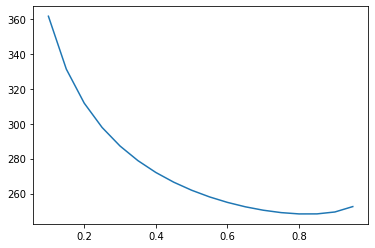

In [ ]:
perplexity = []
d_array = []
d = 0.1
num_line = 200

while d <= 1:  
  d_array.append(d)
  calc_lambda(SEP_BIGRAMS, d, 'buffer.csv') 
  lambda_mat = pd.read_csv('buffer.csv', header=None, index_col=0, na_filter=False)
  LAMBDA_DICT = lambda_mat.to_dict(orient='index')
  perplexity.append(compute_perplexity(DATA_VALID, num_line, d))
  d += 0.05
plt.plot(d_array, perplexity)
plt.show()

In [ ]:
D = [0.4, 0.75, 0.9]
p = []
num_line = 200

for d in D:
  calc_lambda(SEP_BIGRAMS, d, 'buffer.csv') 
  lambda_mat = pd.read_csv('buffer.csv', header=None, index_col=0, na_filter=False)
  LAMBDA_DICT = lambda_mat.to_dict(orient='index')
  p.append(compute_perplexity(DATA_VALID, num_line, d))  
  
for i in range(len(D)):
  print(f"Perplexity with discount = {D[i]}: {p[i]}")
  

Perplexity with discount = 0.4: 272.0562939540664
Perplexity with discount = 0.75: 249.04219722713495
Perplexity with discount = 0.9: 249.40535548154293


## Computing perplexity for valid set and test set

In [ ]:
LAMBDA_DICT, P_CON_DICT, BIGRAMS_DICT, UNIGRAMS_DICT, VOCAB = init_pkn_dict()

In [ ]:
compute_perplexity(DATA_VALID)

290.88591528956294

In [ ]:
compute_perplexity(DATA_TEST)

271.13367112895276

In [ ]:
# with open('word_data_wiki103_train.txt', 'w') as write_file:
#   with open('wiki_train.txt', 'r') as read_file:
#     while True:
#       lines = read_file.readline()
#       if not lines:
#         break
#       if lines[1] == '=' or lines[1] == '\n':
#         continue
#       else:
#         lines = re.compile(r'\.').sub('\n', lines)
#         lines = re.sub('[^A-Za-z\n<> ]+', '', lines)
#         write_file.write(lines)
      


In [ ]:
# with open('processed_valid.txt', 'w') as write_file:
#   with open('word_data_wiki103_valid.txt', 'r') as read_file:
#     while True:
#       lines = read_file.readline()
#       if not lines:
#         break
#       write_file.write('<s> ')
#       write_file.write(lines.strip())
#       write_file.write(' </s>\n')

# Demo on Gradio

In [18]:
LAMBDA_MAT, P_CONTINUATION_MAT, BIGRAMS_MAT, UNIGRAMS_MAT, UNIGRAMS_DICT, VOCAB = init_pkn()

In [19]:
import gradio as gr

def predict_word(preceded_word):
  returned_df = calc_pkn(preceded_word.split()[-1], 5)
  word_predict = list(returned_df.index)
  df= {"Top": [_ + 1 for _ in range(len(word_predict))],
        "Word Predict": [preceded_word + ' ' + word for word in word_predict]
      }
  return pd.DataFrame(df)

outputs = [gr.Dataframe(row_count = (2, "dynamic"), col_count=(2, "fixed"), label="Predictions", headers=["Top","Word Predict"])]
gr.Interface(fn = predict_word, inputs = "text", outputs = outputs).launch(share=True,debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b9414f21-a851-4fe5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b9414f21-a851-4fe5.gradio.live
